In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [0]:
image_shape = (28, 28, 1)
input_shape=[None,28,28,1]
number_of_classes = 10

#Hyper parameters
learning_rate = 0.01
epoch = 15
batch_size = 128

In [0]:
# from google.colab import files
# #files.upload()
# files.os.listdir()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# print("Training data shape: {}".format(train_data.shape))
# print("Test data shape: {}".format(test_data.shape))


In [0]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [5]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(X_train, X_cv) = X_train[5000:], X_train[:5000] 
(y_train, y_cv) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
X_train = X_train.reshape(X_train.shape[0], w, h, 1)
X_cv = X_cv.reshape(X_cv.shape[0], w, h, 1)
X_test = X_test.reshape(X_test.shape[0], w, h, 1)

# X_train = X_train.reshape(X_train.shape[0],*image_shape)
# X_test = X_test.reshape(X_test.shape[0],*image_shape)
# X_cv = X_cv.reshape(X_cv.shape[0],*image_shape)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_cv = tf.keras.utils.to_categorical(y_cv, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", X_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(X_train.shape[0], 'train set')
print(X_cv.shape[0], 'validation set')
print(X_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


In [0]:
def fashion_mnsit_model(input_shape, num_class=10, learning_rate=0.01):
  input_layer = tf.placeholder(tf.float32, shape=input_shape)
  labels=tf.placeholder(tf.float32,shape=[None,num_class])
  train_mode=tf.placeholder(tf.bool)
  
  conv_1 = tf.layers.conv2d(
        inputs=input_layer, 
        filters=32, 
        kernel_size=[3, 3], 
        padding="same", 
        activation=tf.nn.relu)
  
  #pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=[2, 2], strides=1)
  
#   conv_2 = tf.layers.conv2d(
#         inputs=conv_1, 
#         filters=64, 
#         kernel_size=[3, 3], 
#         padding="same", 
#         activation=tf.nn.relu)
  pool_2 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=[2, 2], strides=1)
  
  #pool_2_flat = tf.reshape(pool_2, shape=[-1, 14*14*64])
  pool_2_flat=tf.contrib.layers.flatten(
    pool_2,
    outputs_collections=None,
    scope=None
        )
  
  dense = tf.layers.dense(
        inputs=pool_2_flat, 
        units=32,
        activation=tf.nn.relu)
  
  dropout = tf.layers.dropout(
        inputs=dense, 
        rate=0.2, 
        training= train_mode)
  
  logits = tf.layers.dense(inputs=dropout, units=10)
  
  predictions = {
        "classes" : tf.argmax(input=logits, axis=1),
        "probabilities" : tf.nn.softmax(logits=logits)
    }
  
  
  loss = tf.losses.softmax_cross_entropy(labels, logits)
  
  train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
  accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32))
  
  return { "logits": logits,
             "predictions": predictions,
             "loss": loss,
             "train_op": train_op,
             "accuracy": accuracy,
             "x": input_layer,
             "y": labels,
             "train_mode": train_mode }

In [0]:
tf.reset_default_graph()
model = fashion_mnsit_model(input_shape, number_of_classes, learning_rate)
x = model["x"]
y= model["y"]
train_mode = model["train_mode"]

In [8]:
batch_size = 128
epoch = 25
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_size = X_train.shape[0]
    number_of_batches = int(total_size/batch_size)
    print("Training Started")
    for e in range(epoch):
        epoch_cost = 0
        epoch_accuracy = 0
        for i in range(number_of_batches):
            mini_x = X_train[i*batch_size:(i+1)*batch_size, :, :, :]
            mini_y = y_train[i*batch_size:(i+1)*batch_size, :]
            _, cost = sess.run([model["train_op"], model["loss"]], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:True})
            train_accuracy = sess.run(model["accuracy"], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        
        #If the total number of training examles is not exactly divisible by batch_size, 
        #we have one more batch of size (total_size - number_of_batches*batch_size)
        if total_size % batch_size != 0:
            mini_x = X_train[number_of_batches*batch_size:total_size, :, :, :]
            mini_y = y_train[number_of_batches*batch_size:total_size, :]
            _, cost = sess.run([model["train_op"], model["loss"]], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:True})
            train_accuracy = sess.run(model["accuracy"], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode: False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        
        epoch_cost /= number_of_batches
        
        if total_size % batch_size != 0:
            epoch_accuracy /= (number_of_batches+1)
        else:
            epoch_accuracy /= number_of_batches
        print("Epoch: {} Cost: {} accuracy: {} ".format(e+1, np.squeeze(epoch_cost), epoch_accuracy))
    
    print("Training:End")
    #Cross validation loss and accuracy
    cv_loss, cv_accuracy = sess.run([model["loss"], model["accuracy"]], 
            {x:X_cv, 
             y:y_cv,
             train_mode: False})
    print("Cross validation loss: {} accuracy: {}".format(np.squeeze(cv_loss), cv_accuracy))
    
    #prediction for test set
    test_accuracy, prediction = sess.run([model["accuracy"], 
                                          model["predictions"]["classes"]], 
                                         {x:X_test, y:y_test, train_mode:False})
    print("Test set accuracy {}".format(test_accuracy))
    
    

Training Started
Epoch: 1 Cost: 0.48266709146105047 accuracy: 0.8675128831419834 
Epoch: 2 Cost: 0.3396096537302146 accuracy: 0.9038220138050789 
Epoch: 3 Cost: 0.3015082491375072 accuracy: 0.9163021934586902 
Epoch: 4 Cost: 0.2786824640694198 accuracy: 0.9233780390994494 
Epoch: 5 Cost: 0.26234108185295735 accuracy: 0.9294826902622401 
Epoch: 6 Cost: 0.25088007414674424 accuracy: 0.9330619053785191 
Epoch: 7 Cost: 0.24179270080266854 accuracy: 0.9377229783424111 
Epoch: 8 Cost: 0.2276442211928901 accuracy: 0.9399494582830473 
Epoch: 9 Cost: 0.22362935765362008 accuracy: 0.942707782706549 
Epoch: 10 Cost: 0.21368260942138992 accuracy: 0.9468683931716653 
Epoch: 11 Cost: 0.20108234062617197 accuracy: 0.9508192389510398 
Epoch: 12 Cost: 0.19484498721736293 accuracy: 0.9535181024739908 
Epoch: 13 Cost: 0.1933758712453998 accuracy: 0.9534569899703181 
Epoch: 14 Cost: 0.19672181269714048 accuracy: 0.9536816199158513 
Epoch: 15 Cost: 0.18284366450040213 accuracy: 0.957660544334456 
Epoch: 16

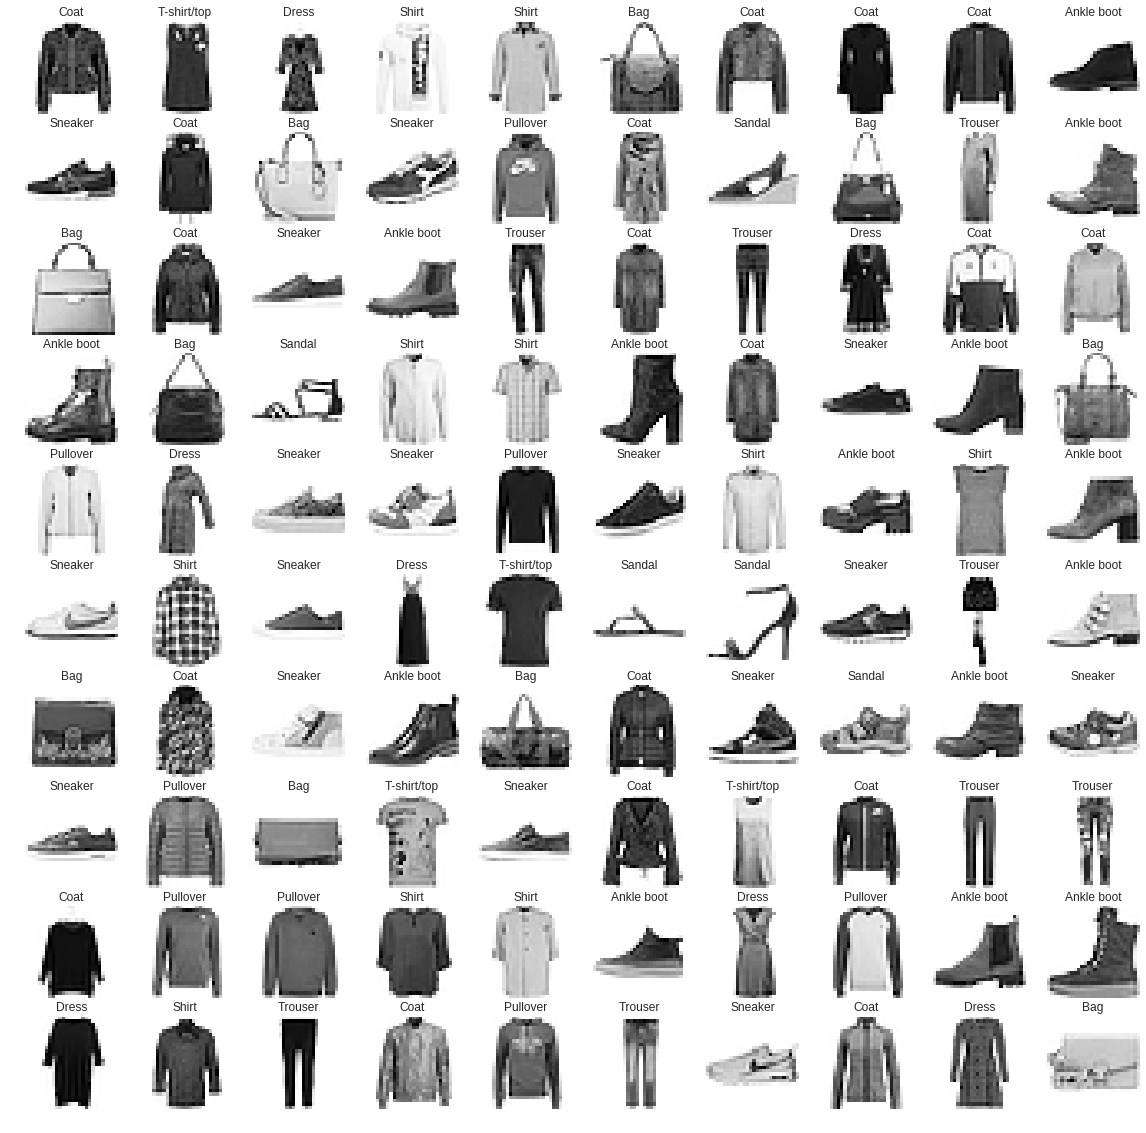

In [9]:
labels={'0':'T-shirt/top', '1': 'Trouser', '2' :'Pullover', '3':'Dress', '4': 'Coat', 
        '5': 'Sandal', '6': 'Shirt', '7': 'Sneaker', '8': 'Bag', '9': 'Ankle boot'} 

#Let us choose random 100 images from test set and see 
#actual label and predicted label by our model for the same
predicted_labels = prediction
permutations = np.random.permutation(10000)

fig, axs = plt.subplots(10, 10, figsize = (20, 20))
for r in range(10):
  for c in range(10):
    axs[r, c].imshow(np.reshape(X_test[permutations[10*r+c], :, :, :]*255, [input_shape[1], input_shape[2]]), cmap='Greys')
    axs[r, c].axis('off')
    axs[r, c].set_title(labels[str(predicted_labels[permutations[10*r+c]])])